In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

In [5]:
import zipfile
zip_path = "D:/career/master/da_models/final_project/data/onlret_transaction.zip"
with zipfile.ZipFile(zip_path, "r") as z:
    # Lấy file CSV đầu tiên
    csv_name = next(f for f in z.namelist() if f.endswith(".csv"))
    with z.open(csv_name) as f:
        df = pd.read_csv(f, dtype={"CustomerID":str, "InvoiceNo":str})
df.head(2)

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Status,CustomerType
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,1,1
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,1,1


In [6]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Quantity', 'InvoiceDate', 'UnitPrice',
       'CustomerID', 'Country', 'TotalPrice', 'Status', 'CustomerType'],
      dtype='object')

### 1. Chuẩn hóa dữ liệu

In [7]:
df["InvoiceDate"] = pd.to_datetime(df.InvoiceDate)

In [8]:
df["d"] = df["InvoiceDate"].dt.floor("D")

In [9]:
daily_df = df.groupby(by=["CustomerID", "d"]).agg(sum_revenue=("TotalPrice", "sum"), sum_quantity=("Quantity", "sum"), cnt_bill=("InvoiceNo", "nunique")).reset_index()

In [10]:
daily_df.head(2)

,CustomerID,d,sum_revenue,sum_quantity,cnt_bill
0,12346,2011-01-18,0.00,0,2
1,12347,2010-12-07,711.79,319,1


In [11]:
buyertype_df = pd.read_csv("buyer_type.csv", dtype={"CustomerID":str})
tier_df = pd.read_csv("tier_customer.csv", dtype={"CustomerID":str})

In [12]:
df1 = daily_df.merge(buyertype_df, on="CustomerID", how="inner")

In [34]:
df2 = daily_df.merge(tier_df[["CustomerID", "Tier"]], on="CustomerID", how="inner")

### Phân tích insights

#### Phân tích nhóm mua lẻ

In [14]:
retail = df1[df1.BuyerType=="Retail"]
retail_ts_df = retail.groupby("d").agg(sum_revenue=("sum_revenue", "sum"), sum_quantity=("sum_quantity", "sum"), cnt_bill=("cnt_bill", "sum")).reset_index()
retail_ts_df.columns

Index(['d', 'sum_revenue', 'sum_quantity', 'cnt_bill'], dtype='object')

In [15]:
#### Hàm điền thiếu

def fill_missing_by_moving_average(
    df: pd.DataFrame,
    time_col: str,
    value_col: str,
    window: int = 7,
    freq: str = "D",
    center: bool = True,
    min_periods: int | None = None,
    only_fill_missing_days: bool = True,
    keep_original_time_col: bool = True,
) -> pd.DataFrame:
    """
    Fill missing values on missing dates using moving average.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    time_col : str
        Column name for time index (datetime-like).
    value_col : str
        Column name for the numeric series to fill.
    window : int
        Moving average window size.
    freq : str
        Frequency for reindexing (default daily 'D').
    center : bool
        If True, use centered moving average; otherwise trailing window.
    min_periods : int | None
        Minimum periods for rolling mean. If None, auto = max(1, window//2).
    only_fill_missing_days : bool
        If True, fill only rows introduced by reindexing (missing dates),
        leaving existing NaNs untouched. If False, fill all NaNs.
    keep_original_time_col : bool
        If True, keep time_col as a normal column; else set as index.

    Returns
    -------
    pd.DataFrame
        New dataframe with a continuous date range and filled values.
    """

    if window <= 0:
        raise ValueError("window must be a positive integer")

    out = df.copy()

    # 1) Ensure datetime
    out[time_col] = pd.to_datetime(out[time_col], errors="coerce")
    out = out.dropna(subset=[time_col]).copy()

    # 2) Sort and aggregate duplicates per day (important if you have multiple rows/day)
    #    If your df is already daily aggregated, this does no harm.
    out = out.sort_values(time_col)
    # normalize to daily boundary if freq='D'
    if freq.upper() == "D":
        out["_tmp_date"] = out[time_col].dt.floor("D")
        grp_col = "_tmp_date"
    else:
        grp_col = time_col

    # Keep other columns? Here we focus on time/value only.
    # If you want to preserve additional columns, do it before/after.
    out_daily = (out.groupby(grp_col, as_index=True)[value_col]
                   .sum(min_count=1))  # sum revenue etc.; change to mean if needed

    out_daily.index.name = time_col

    # 3) Reindex to full date range
    full_idx = pd.date_range(out_daily.index.min(), out_daily.index.max(), freq=freq)
    reindexed = out_daily.reindex(full_idx)

    # mask missing days introduced by reindex
    missing_day_mask = reindexed.isna()

    # 4) Rolling mean (built-in)
    if min_periods is None:
        min_periods = max(1, window // 2)

    rolling_mean = reindexed.rolling(window=window, min_periods=min_periods, center=center).mean()

    # 5) Fill
    if only_fill_missing_days:
        filled = reindexed.copy()
        filled[missing_day_mask] = rolling_mean[missing_day_mask]
    else:
        filled = reindexed.fillna(rolling_mean)

    # 6) (Optional) If edges are still NaN (not enough points), fallback to ffill/bfill
    #    Comment out if you don't want this behavior
    filled = filled.ffill().bfill()

    # 7) Return as DataFrame
    result = filled.to_frame(name=value_col)
    result[time_col] = result.index

    # clean temp
    if "_tmp_date" in out.columns:
        pass

    if keep_original_time_col:
        result = result[[time_col, value_col]]
        result = result.reset_index(drop=True)
    else:
        result = result.set_index(time_col)

    return result

In [16]:
rev_retail_ts_df = fill_missing_by_moving_average(
    retail_ts_df,
    time_col="d",
    value_col ="sum_revenue",
    window = 5,
    freq = "D",
    center = True,
    min_periods = None,
    only_fill_missing_days = True,
    keep_original_time_col = True,
)

In [17]:
def plot_timeseries(df, time_col, value_col, figsize=(12,4), title=None, color="#2F80ED"):
    """
    Simple time-series plot: df[time_col] vs df[value_col]
    Assumes df is already aggregated and cleaned.
    """

    sns.set_theme(style="whitegrid")

    # Chuẩn hoá datetime + sort
    x = df.copy()
    x[time_col] = pd.to_datetime(x[time_col], errors="coerce")
    x = x.dropna(subset=[time_col]).sort_values(time_col)

    # Tạo figure
    fig, ax = plt.subplots(figsize=figsize)

    # Vẽ line chart
    ax.plot(x[time_col], x[value_col], color=color, lw=2)

    # Title
    if title is None:
        title = f"{value_col} over time"
    ax.set_title(title, pad=12, fontweight="bold")

    # Nhãn trục
    ax.set_xlabel("Time")
    ax.set_ylabel(value_col)

    # Format trục y cho đẹp
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

    # Layout
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

    return fig, ax

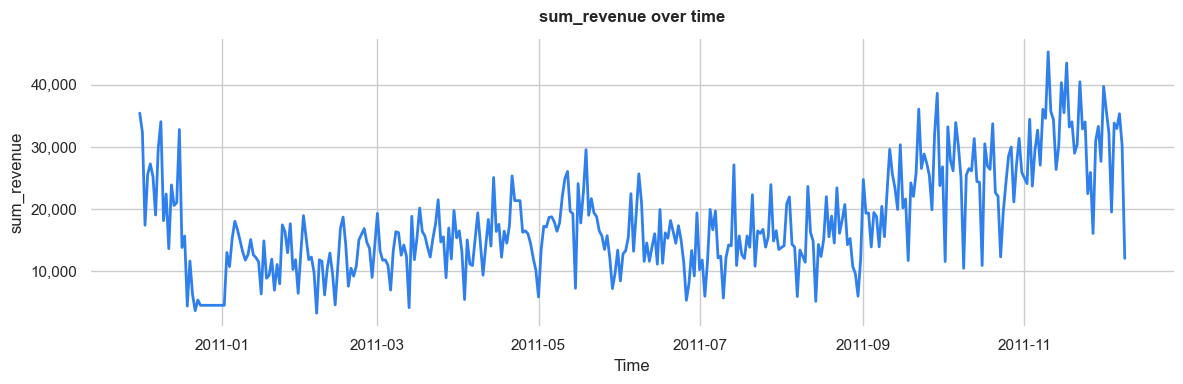

(<Figure size 1200x400 with 1 Axes>,
 <Axes: title={'center': 'sum_revenue over time'}, xlabel='Time', ylabel='sum_revenue'>)

In [18]:
plot_timeseries(rev_retail_ts_df, time_col="d", value_col="sum_revenue")

In [21]:
def show_ts_decomposition_insights(
    df: pd.DataFrame,
    time_col: str,
    value_col: str,
    freq: str = "D",
    period: int | None = None,
    agg: str = "sum",                   # "sum" cho revenue; "mean" cho AOV
    fill: str = "interpolate",          # "interpolate" | "ffill" | "zero" | None
    model: str = "additive",
    log_transform: bool = False,
    robust: bool = True,
    title: str | None = None,
    currency: bool = True,
    figsize: tuple = (14, 8),
    accent: str = "#2F80ED",
    neutral: str = "#BDBDBD",
    dark: str = "#333333",
):
    """
    Decompose time-series: y = trend + seasonality + residual
    Show story-driven insights + clean publication-ready plots.
    """

    # -----------------------
    # 0) Validate
    # -----------------------
    if time_col not in df.columns:
        raise ValueError(f"Missing column: {time_col}")
    if value_col not in df.columns:
        raise ValueError(f"Missing column: {value_col}")

    x = df[[time_col, value_col]].copy()
    x[time_col] = pd.to_datetime(x[time_col], errors="coerce")
    x = x.dropna(subset=[time_col]).sort_values(time_col)

    # -----------------------
    # 1) Aggregate
    # -----------------------
    x = x.set_index(time_col)

    if agg == "sum":
        ts = x[value_col].resample(freq).sum(min_count=1)
    elif agg == "mean":
        ts = x[value_col].resample(freq).mean()
    elif agg == "median":
        ts = x[value_col].resample(freq).median()
    else:
        raise ValueError("agg must be one of: sum, mean, median")

    if fill is None:
        ts_filled = ts.copy()
    elif fill == "interpolate":
        ts_filled = ts.interpolate(method="time")
    elif fill == "ffill":
        ts_filled = ts.ffill()
    elif fill == "zero":
        ts_filled = ts.fillna(0)
    else:
        raise ValueError("fill must be one of: interpolate, ffill, zero, None")

    ts_filled = ts_filled.ffill().bfill()

    ts_used = ts_filled.copy()
    if log_transform:
        if (ts_used <= 0).any():
            raise ValueError("log_transform=True requires all values > 0.")
        ts_used = np.log(ts_used)

    # -----------------------
    # 2) Period
    # -----------------------
    if period is None:
        f = freq.upper()
        if f.startswith("D"):
            period = 7
        elif f.startswith("H"):
            period = 24
        elif f.startswith("W"):
            period = 52
        elif f.startswith("M"):
            period = 12
        else:
            period = 7

    # -----------------------
    # 3) Decomposition
    # -----------------------
    try:
        from statsmodels.tsa.seasonal import STL
        res = STL(ts_used, period=period, robust=robust).fit()
        trend, seasonal, resid = res.trend, res.seasonal, res.resid
        method_used = "STL"
    except Exception:
        from statsmodels.tsa.seasonal import seasonal_decompose
        dec = seasonal_decompose(ts_used, model="additive", period=period, extrapolate_trend="freq")
        trend, seasonal, resid = dec.trend, dec.seasonal, dec.resid
        method_used = "seasonal_decompose"

    if log_transform:
        observed = np.exp(ts_used)
        trend_report = np.exp(trend)
        seasonal_report = np.exp(seasonal)
        resid_report = np.exp(resid)
    else:
        observed = ts_used
        trend_report = trend
        seasonal_report = seasonal
        resid_report = resid

    comp = pd.DataFrame({
        "observed": observed,
        "trend": trend_report,
        "seasonal": seasonal_report,
        "residual": resid_report
    }).dropna()

    # -----------------------
    # 4) Insights
    # -----------------------
    y = comp["observed"]

    t0, t1 = comp["trend"].iloc[0], comp["trend"].iloc[-1]
    trend_change_abs = t1 - t0
    trend_change_pct = (trend_change_abs / (y.mean() if y.mean() != 0 else 1)) * 100

    idx = np.arange(len(comp))
    slope = np.polyfit(idx, comp["trend"].values, 1)[0]

    if log_transform:
        season_amp = comp["seasonal"].max() / comp["seasonal"].min()
        season_amp_desc = f"{season_amp:.2f}× (max/min factor)"
        resid_desc = f"{np.std(comp['residual']):.3f} (std factor)"
    else:
        season_amp = comp["seasonal"].max() - comp["seasonal"].min()
        season_amp_desc = f"{season_amp:,.0f} (peak-to-trough)"
        resid_desc = f"{comp['residual'].std():,.0f} (std)"

    var_tr = np.var(comp["trend"])
    var_se = np.var(comp["seasonal"])
    var_re = np.var(comp["residual"])
    denom = var_tr + var_se + var_re if (var_tr + var_se + var_re) > 0 else 1

    share_tr = var_tr / denom
    share_se = var_se / denom
    share_re = var_re / denom

    # -----------------------
    # 5) Plot (FIXED LAYOUT)
    # -----------------------
    sns.set_theme(style="whitegrid")
    fig = plt.figure(figsize=figsize)

    gs = fig.add_gridspec(
        3, 2,
        width_ratios=[3.2, 1.4],
        height_ratios=[2.2, 1.2, 1.2],
        hspace=0.25,
        wspace=0.15
    )

    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0], sharex=ax0)
    ax2 = fig.add_subplot(gs[2, 0], sharex=ax0)
    ax_text = fig.add_subplot(gs[:, 1])
    ax_text.axis("off")

    ax0.plot(comp.index, comp["observed"], color=neutral, lw=1.2, alpha=0.75)
    ax0.plot(comp.index, comp["trend"], color=accent, lw=2.6)
    ax0.fill_between(comp.index, comp["trend"], comp["observed"], color=accent, alpha=0.05)

    if title is None:
        title = f"Time-series decomposition: {value_col}"
    ax0.set_title(title, fontweight="bold", pad=12)

    callout = (
        f"Decomposition ({method_used})\n"
        f"• Period: {period} ({freq})\n\n"
        f"Trend\n"
        f"• Δ = {trend_change_abs:,.0f}\n"
        f"• ≈ {trend_change_pct:.1f}% of mean\n"
        f"• slope ≈ {slope:,.2f} / step\n\n"
        f"Seasonality\n"
        f"• amplitude: {season_amp_desc}\n\n"
        f"Residual\n"
        f"• volatility: {resid_desc}\n\n"
        f"Variability share\n"
        f"• Trend: {share_tr:.0%}\n"
        f"• Seasonality: {share_se:.0%}\n"
        f"• Residual: {share_re:.0%}"
    )

    ax_text.text(
        0, 0.5, callout,
        ha="left", va="center",
        fontsize=10.5,
        color="#555555",
        linespacing=1.25,
        bbox=dict(boxstyle="round,pad=0.7", facecolor="white", edgecolor="#DDDDDD")
    )

    ax1.plot(comp.index, comp["seasonal"], color=dark, lw=1.8)
    ax1.set_ylabel("Seasonal")
    ax1.axhline(1 if log_transform else 0, ls="--", lw=1, color="#AAAAAA")

    ax2.plot(comp.index, comp["residual"], color="#EB5757", lw=1.2)
    ax2.set_ylabel("Residual")
    ax2.axhline(1 if log_transform else 0, ls="--", lw=1, color="#AAAAAA")
    ax2.set_xlabel("Time")

    for ax in [ax0, ax1, ax2]:
        ax.grid(True, axis="y", alpha=0.35)
        sns.despine(ax=ax, left=True, bottom=True)

    if currency and not log_transform:
        ax0.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

    plt.tight_layout()

    # -----------------------
    # 6) Print summary
    # -----------------------
    print("===== Time-Series Decomposition Insights =====")
    print(f"Method: {method_used} | freq={freq} | period={period}")
    print(f"Trend Δ: {trend_change_abs:,.0f} ({trend_change_pct:.1f}%)")
    print(f"Seasonality: {season_amp_desc}")
    print(f"Residual: {resid_desc}")
    print("=============================================")

    return {
        "components": comp,
        "fig": fig
    }


===== Time-Series Decomposition Insights =====
Method: STL | freq=D | period=7
Trend Δ: 2,957 (16.5%)
Seasonality: 25,200 (peak-to-trough)
Residual: 3,294 (std)


{'components':             observed         trend      seasonal      residual
 d                                                             
 2010-12-01  35428.88  25440.253313   9214.556144    774.070543
 2010-12-02  32367.24  24978.819713   6838.814253    549.606034
 2010-12-03  17397.55  24531.172446  -6268.625899   -864.996546
 2010-12-04  25569.73  24093.730934   1669.717190   -193.718123
 2010-12-05  27265.16  23663.548320  -9401.959188  13003.570867
 ...              ...           ...           ...           ...
 2011-12-05  33832.52  28080.327769   5674.884175     77.308056
 2011-12-06  32964.88  28186.677375   6296.971170  -1518.768545
 2011-12-07  35338.92  28273.903944   5469.181646   1595.834410
 2011-12-08  30220.35  28344.371682   1868.092796      7.885522
 2011-12-09  12070.07  28397.390317 -15302.992255  -1024.328063
 
 [374 rows x 4 columns],
 'fig': <Figure size 1400x800 with 4 Axes>}

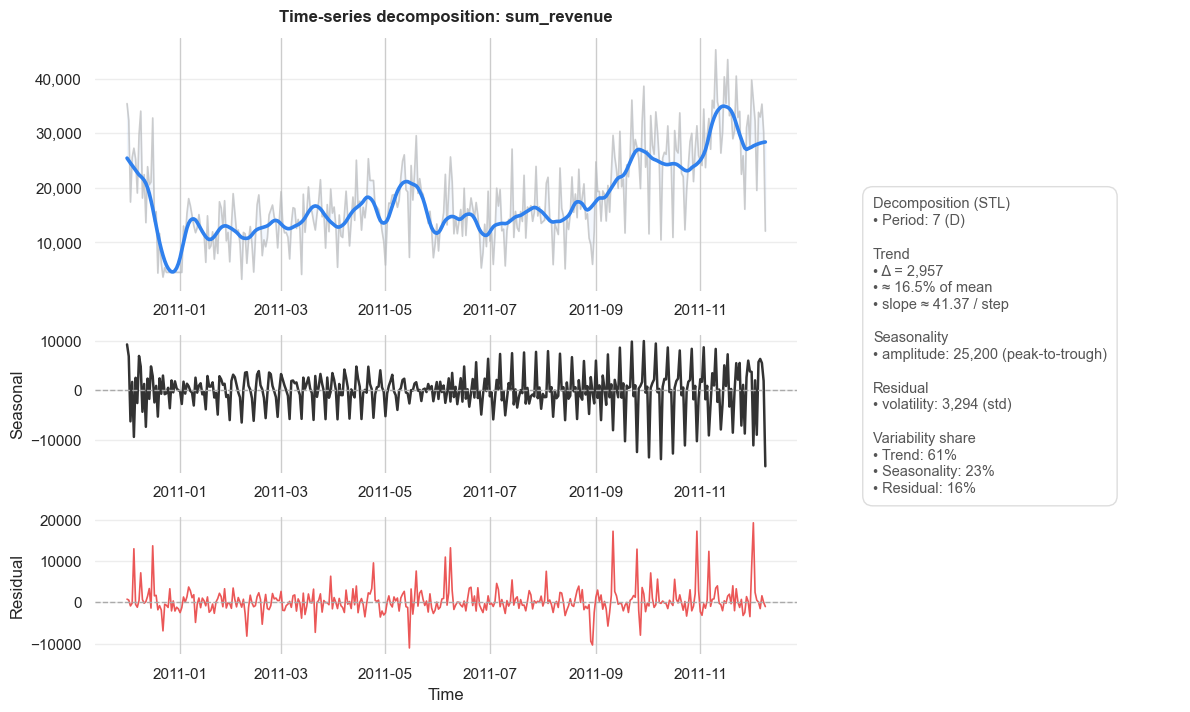

In [22]:
show_ts_decomposition_insights(
    rev_retail_ts_df, time_col="d", value_col="sum_revenue")


In [47]:
def forecast_revenue_30d_with_eval(
    df: pd.DataFrame,
    time_col: str,
    value_col: str,
    horizon: int = 30,
    period: int = 7,
    show_plot: bool = True
):
    """
    STL + SARIMAX forecasting with:
    - 11:1 train-test split
    - Test vs Forecast visualization
    - Growth interpretation

    Returns
    -------
    dict:
        - forecast_df
        - test_df
        - growth_summary
        - model_info
    """

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from statsmodels.tsa.seasonal import STL
    from statsmodels.tsa.statespace.sarimax import SARIMAX

    # =======================
    # 0) Prepare series
    # =======================
    x = df[[time_col, value_col]].copy()
    x[time_col] = pd.to_datetime(x[time_col])
    x = x.sort_values(time_col)

    ts = (
        x
        .set_index(time_col)[value_col]
        .asfreq("D")
        .interpolate("time")
    )

    # =======================
    # 1) Train / Test split (11:1)
    # =======================
    n = len(ts)
    split_idx = int(n * 11 / 12)

    ts_train = ts.iloc[:split_idx]
    ts_test = ts.iloc[split_idx:]

    # =======================
    # 2) STL decomposition (train)
    # =======================
    stl = STL(ts_train, period=period, robust=True)
    res = stl.fit()

    trend = res.trend
    seasonal = res.seasonal
    resid = res.resid

    # =======================
    # 3) SARIMAX on residual
    # =======================
    model = SARIMAX(
        resid,
        order=(14, 1, 3),
        seasonal_order=(0, 1, 1, period),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    fit = model.fit(disp=False)

    # =======================
    # 4) Predict TEST part
    # =======================
    resid_test_pred = fit.get_forecast(steps=len(ts_test)).predicted_mean

    idx = np.arange(len(trend))
    slope, intercept = np.polyfit(idx, trend.values, 1)

    future_idx_test = np.arange(len(trend), len(trend) + len(ts_test))
    trend_test_pred = slope * future_idx_test + intercept

    seasonal_pattern = seasonal[-period:]
    seasonal_test_pred = np.tile(
        seasonal_pattern,
        int(np.ceil(len(ts_test) / period))
    )[:len(ts_test)]

    test_pred = trend_test_pred + seasonal_test_pred + resid_test_pred.values

    test_df = pd.DataFrame({
        "date": ts_test.index,
        "actual": ts_test.values,
        "predicted": test_pred
    })

    # =======================
    # 5) Forecast FUTURE
    # =======================
    resid_forecast = fit.get_forecast(steps=horizon).predicted_mean

    future_idx_fc = np.arange(
        len(trend) + len(ts_test),
        len(trend) + len(ts_test) + horizon
    )

    trend_forecast = slope * future_idx_fc + intercept
    seasonal_forecast = np.tile(
        seasonal_pattern,
        int(np.ceil(horizon / period))
    )[:horizon]

    forecast = trend_forecast + seasonal_forecast + resid_forecast.values

    forecast_index = pd.date_range(
        ts.index[-1] + pd.Timedelta(days=1),
        periods=horizon,
        freq="D"
    )

    forecast_df = pd.DataFrame({
        "date": forecast_index,
        "forecast_revenue": forecast
    })

    # =======================
    # 6) Growth interpretation
    # =======================
    last_30_actual = ts.iloc[-30:].mean()
    next_30_forecast = forecast_df["forecast_revenue"].mean()

    growth_abs = next_30_forecast - last_30_actual
    growth_pct = (growth_abs / last_30_actual) * 100 if last_30_actual != 0 else np.nan

    if growth_pct > 5:
        trend_desc = "tăng rõ rệt"
    elif growth_pct > 0:
        trend_desc = "tăng nhẹ"
    elif growth_pct > -5:
        trend_desc = "đi ngang / giảm nhẹ"
    else:
        trend_desc = "giảm đáng kể"

    growth_summary = {
        "last_30d_avg": float(last_30_actual),
        "next_30d_forecast_avg": float(next_30_forecast),
        "growth_abs": float(growth_abs),
        "growth_pct": float(growth_pct),
        "interpretation": trend_desc
    }

    # =======================
    # 7) Visualization
    # =======================
    if show_plot:
        plt.figure(figsize=(13, 4))

        plt.plot(ts_train.index, ts_train.values, label="Train", alpha=0.7)
        plt.plot(
            test_df["date"],
            test_df["actual"],
            label="Test (Actual)",
            linewidth=2
        )
        plt.plot(
            test_df["date"],
            test_df["predicted"],
            label="Test (Predicted)",
            linestyle="--"
        )
        plt.plot(
            forecast_df["date"],
            forecast_df["forecast_revenue"],
            label="Forecast (30d)",
            linewidth=2
        )

        plt.axvline(ts_test.index[0], linestyle=":", alpha=0.6)
        plt.title("Train – Test – Forecast Revenue")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return {
        "forecast_df": forecast_df,
        "test_df": test_df,
        "growth_summary": growth_summary,
        "model_info": {
            "pipeline": "STL → SARIMAX(residual)",
            "seasonal_period": period,
            "train_test_split": "11:1"
        }
    }


In [55]:
def forecast_revenue_30d_prophet_with_eval(
    df: pd.DataFrame,
    time_col: str,
    value_col: str,
    horizon: int = 30,
    period: int = 7,
    show_plot: bool = True
):
    """
    Prophet forecasting with:
    - 11:1 train-test split
    - Weekly seasonality
    - Test vs Forecast visualization
    - Growth interpretation
    """

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from prophet import Prophet

    # =======================
    # 0) Prepare data
    # =======================
    x = df[[time_col, value_col]].copy()
    x[time_col] = pd.to_datetime(x[time_col])
    x = x.sort_values(time_col)

    ts = (
        x
        .set_index(time_col)[value_col]
        .asfreq("D")
        .interpolate("time")
    )

    prophet_df = ts.reset_index()
    prophet_df.columns = ["ds", "y"]

    # =======================
    # 1) Train / Test split (11:1)
    # =======================
    n = len(prophet_df)
    split_idx = int(n * 11 / 12)

    train_df = prophet_df.iloc[:split_idx]
    test_df = prophet_df.iloc[split_idx:]

    # =======================
    # 2) Prophet model
    # =======================
    model = Prophet(
        weekly_seasonality=True,
        daily_seasonality=False,
        yearly_seasonality=False,
        changepoint_prior_scale=0.2,   # cho phép trend đổi mạnh hơn
        seasonality_prior_scale=10.0
    )

    model.fit(train_df)

    # =======================
    # 3) Predict TEST
    # =======================
    future_test = test_df[["ds"]]
    test_forecast = model.predict(future_test)

    test_eval_df = pd.DataFrame({
        "date": test_df["ds"].values,
        "actual": test_df["y"].values,
        "predicted": test_forecast["yhat"].values
    })

    # =======================
    # 4) Forecast FUTURE
    # =======================
    future_full = model.make_future_dataframe(periods=horizon, freq="D")
    forecast_full = model.predict(future_full)

    forecast_df = forecast_full.tail(horizon)[["ds", "yhat"]]
    forecast_df.columns = ["date", "forecast_revenue"]

    # =======================
    # 5) Growth interpretation
    # =======================
    last_30_actual = ts.iloc[-30:].mean()
    next_30_forecast = forecast_df["forecast_revenue"].mean()

    growth_abs = next_30_forecast - last_30_actual
    growth_pct = (growth_abs / last_30_actual) * 100 if last_30_actual != 0 else np.nan

    if growth_pct > 5:
        trend_desc = "tăng rõ rệt"
    elif growth_pct > 0:
        trend_desc = "tăng nhẹ"
    elif growth_pct > -5:
        trend_desc = "đi ngang / giảm nhẹ"
    else:
        trend_desc = "giảm đáng kể"

    growth_summary = {
        "last_30d_avg": float(last_30_actual),
        "next_30d_forecast_avg": float(next_30_forecast),
        "growth_abs": float(growth_abs),
        "growth_pct": float(growth_pct),
        "interpretation": trend_desc
    }

    # =======================
    # 6) Visualization
    # =======================
    if show_plot:
        plt.figure(figsize=(13, 4))

        plt.plot(
            train_df["ds"],
            train_df["y"],
            label="Train",
            alpha=0.7
        )
        plt.plot(
            test_eval_df["date"],
            test_eval_df["actual"],
            label="Test (Actual)",
            linewidth=2
        )
        plt.plot(
            test_eval_df["date"],
            test_eval_df["predicted"],
            label="Test (Predicted)",
            linestyle="--"
        )
        plt.plot(
            forecast_df["date"],
            forecast_df["forecast_revenue"],
            label="Forecast (30d)",
            linewidth=2
        )

        plt.axvline(test_eval_df["date"].iloc[0], linestyle=":", alpha=0.6)
        plt.title("Train – Test – Forecast Revenue (Prophet)")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return {
        "forecast_df": forecast_df,
        "test_df": test_eval_df,
        "growth_summary": growth_summary,
        "model_info": {
            "model": "Prophet",
            "weekly_seasonality": True,
            "changepoint_prior_scale": 0.2,
            "train_test_split": "11:1"
        }
    }


C:\Users\phong\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


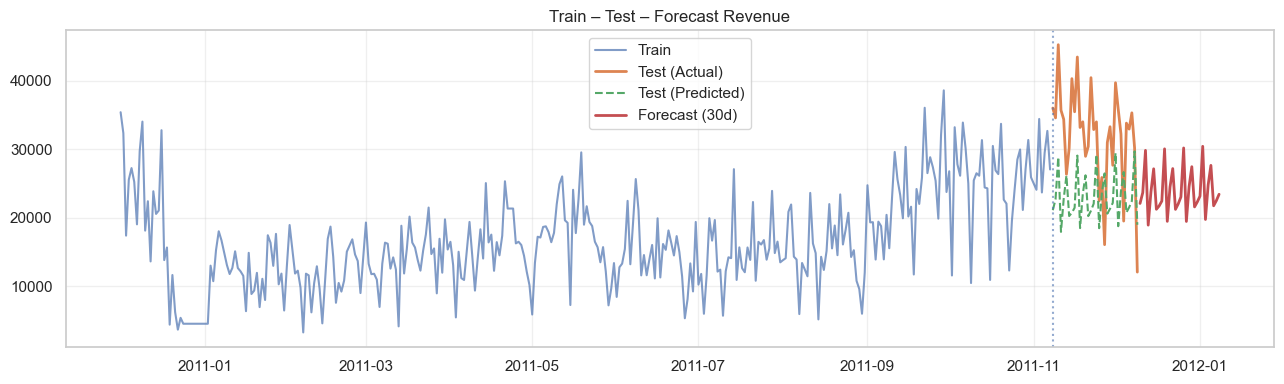

{'forecast_df':          date  forecast_revenue
 0  2011-12-10      22097.243833
 1  2011-12-11      23680.017721
 2  2011-12-12      29855.682800
 3  2011-12-13      18930.460753
 4  2011-12-14      23770.998736
 5  2011-12-15      27160.803136
 6  2011-12-16      21245.890193
 7  2011-12-17      21728.368633
 8  2011-12-18      22451.712138
 9  2011-12-19      30074.876463
 10 2011-12-20      19482.459474
 11 2011-12-21      24489.737628
 12 2011-12-22      27194.011341
 13 2011-12-23      21234.234136
 14 2011-12-24      22023.492002
 15 2011-12-25      23051.022940
 16 2011-12-26      30206.963246
 17 2011-12-27      19468.521227
 18 2011-12-28      24558.681974
 19 2011-12-29      27469.030830
 20 2011-12-30      21594.693773
 21 2011-12-31      22310.422619
 22 2012-01-01      23170.410145
 23 2012-01-02      30446.624586
 24 2012-01-03      19758.436513
 25 2012-01-04      24828.017513
 26 2012-01-05      27661.172300
 27 2012-01-06      21759.472016
 28 2012-01-07      22507.99

In [48]:
forecast_revenue_30d_with_eval(
    rev_retail_ts_df,
    time_col = "d",
    value_col = "sum_revenue",
    horizon = 30,
    period = 7,
    show_plot = True
)

16:38:37 - cmdstanpy - INFO - Chain [1] start processing
16:38:38 - cmdstanpy - INFO - Chain [1] done processing


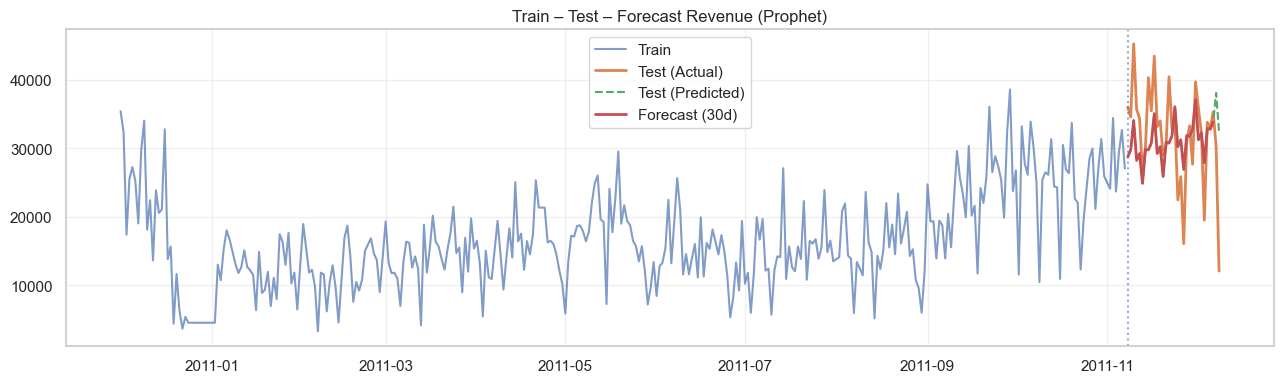

{'forecast_df':           date  forecast_revenue
 342 2011-11-08      28759.531827
 343 2011-11-09      29801.463040
 344 2011-11-10      34074.909811
 345 2011-11-11      28244.505917
 346 2011-11-12      29243.109553
 347 2011-11-13      24896.455722
 348 2011-11-14      29862.885594
 349 2011-11-15      29769.398217
 350 2011-11-16      30811.329431
 351 2011-11-17      35084.776202
 352 2011-11-18      29254.372308
 353 2011-11-19      30252.975943
 354 2011-11-20      25906.322113
 355 2011-11-21      30872.751985
 356 2011-11-22      30779.264608
 357 2011-11-23      31821.195821
 358 2011-11-24      36094.642592
 359 2011-11-25      30264.238699
 360 2011-11-26      31262.842334
 361 2011-11-27      26916.188504
 362 2011-11-28      31882.618375
 363 2011-11-29      31789.130998
 364 2011-11-30      32831.062212
 365 2011-12-01      37104.508983
 366 2011-12-02      31274.105089
 367 2011-12-03      32272.708724
 368 2011-12-04      27926.054894
 369 2011-12-05      32892.484766

In [56]:
forecast_revenue_30d_prophet_with_eval(
    rev_retail_ts_df,
    time_col = "d",
    value_col = "sum_revenue",
    horizon = 30,
    period = 7,
    show_plot = True
)

#### Phân tích nhóm mua sỉ

In [23]:
wsale = df1[df1.BuyerType=="Wholesale"]
wsale_ts_df = wsale.groupby("d").agg(sum_revenue=("sum_revenue", "sum"), sum_quantity=("sum_quantity", "sum"), cnt_bill=("cnt_bill", "sum")).reset_index()
wsale_ts_df.columns

Index(['d', 'sum_revenue', 'sum_quantity', 'cnt_bill'], dtype='object')

In [59]:
rev_wsale_ts_df = fill_missing_by_moving_average(
    wsale_ts_df,
    time_col="d",
    value_col ="sum_revenue",
    window = 5,
    freq = "D",
    center = True,
    min_periods = None,
    only_fill_missing_days = True,
    keep_original_time_col = True,
)

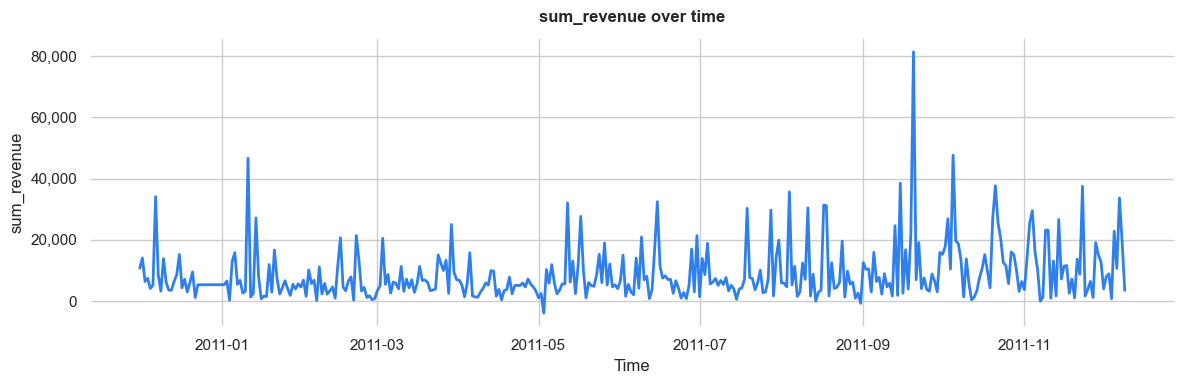

(<Figure size 1200x400 with 1 Axes>,
 <Axes: title={'center': 'sum_revenue over time'}, xlabel='Time', ylabel='sum_revenue'>)

In [60]:
plot_timeseries(rev_wsale_ts_df, time_col="d", value_col="sum_revenue")

===== Time-Series Decomposition Insights =====
Method: STL | freq=D | period=7
Trend Δ: -3,151 (-35.6%)
Seasonality: 37,424 (peak-to-trough)
Residual: 7,900 (std)


{'components':               observed         trend      seasonal      residual
 d                                                               
 2010-12-01  10763.8600  13133.608074  -2109.457503   -260.290570
 2010-12-02  14092.3700  12774.076653   1229.115698     89.177649
 2010-12-03   6395.6600  12409.151471  -6134.080360    120.588889
 2010-12-04   7456.8825  12038.095019  -4400.435682   -180.776836
 2010-12-05   4115.4400  11659.638052  -7518.566810    -25.631242
 ...                ...           ...           ...           ...
 2011-12-05  22804.9600  11352.936835  11286.879716    165.143449
 2011-12-06  10694.3200  11034.778560    839.394920  -1179.853479
 2011-12-07  33652.3500  10696.283663  22190.864787    765.201551
 2011-12-08  19491.8000  10344.525789 -14522.351998  23669.626210
 2011-12-09   3490.1400   9982.910258  -6176.954029   -315.816229
 
 [374 rows x 4 columns],
 'fig': <Figure size 1400x800 with 4 Axes>}

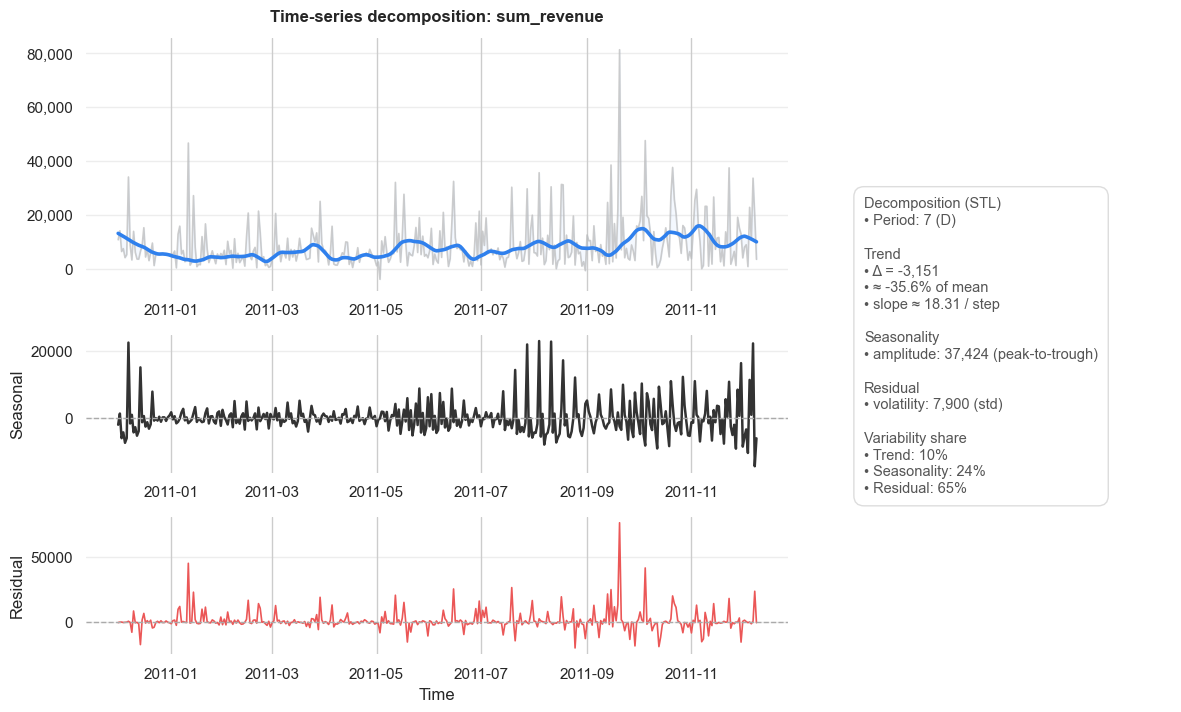

In [61]:
show_ts_decomposition_insights(
    rev_wsale_ts_df, time_col="d", value_col="sum_revenue")

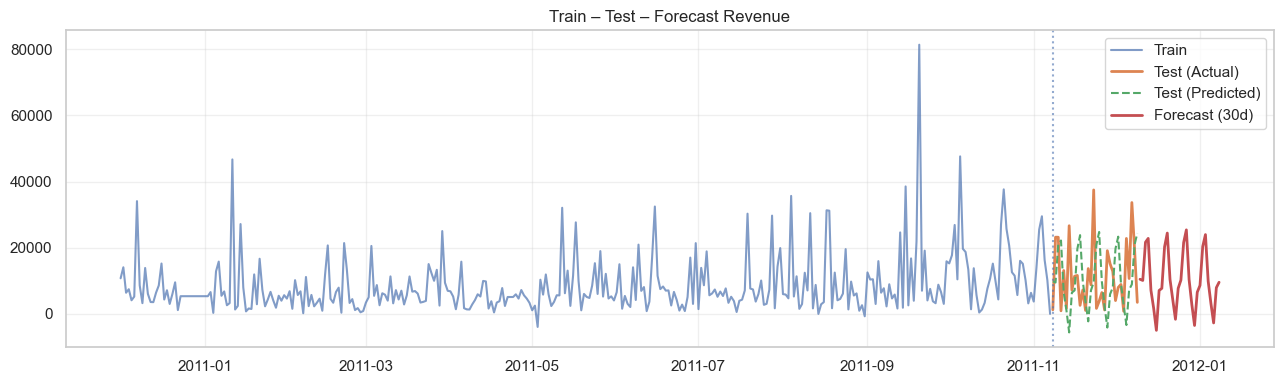

{'forecast_df':          date  forecast_revenue
 0  2011-12-10      10468.856383
 1  2011-12-11      10109.585551
 2  2011-12-12      21665.674027
 3  2011-12-13      22812.827322
 4  2011-12-14       7158.960021
 5  2011-12-15       1707.548722
 6  2011-12-16      -4969.422710
 7  2011-12-17       7065.178729
 8  2011-12-18       7733.769464
 9  2011-12-19      20242.269661
 10 2011-12-20      24429.132098
 11 2011-12-21      10413.894093
 12 2011-12-22       4358.873690
 13 2011-12-23      -1623.096594
 14 2011-12-24       7727.160244
 15 2011-12-25      10227.052946
 16 2011-12-26      21560.563958
 17 2011-12-27      25395.316145
 18 2011-12-28      10359.504026
 19 2011-12-29       2874.454709
 20 2011-12-30      -3497.423319
 21 2011-12-31       6557.599034
 22 2012-01-01       8614.008562
 23 2012-01-02      20367.687739
 24 2012-01-03      23967.588636
 25 2012-01-04       9889.356447
 26 2012-01-05       3202.039478
 27 2012-01-06      -2733.483733
 28 2012-01-07       7929.68

In [62]:
forecast_revenue_30d_with_eval(
    rev_wsale_ts_df,
    time_col = "d",
    value_col = "sum_revenue",
    horizon = 30,
    period = 7,
    show_plot = True
)

16:43:53 - cmdstanpy - INFO - Chain [1] start processing
16:43:53 - cmdstanpy - INFO - Chain [1] done processing


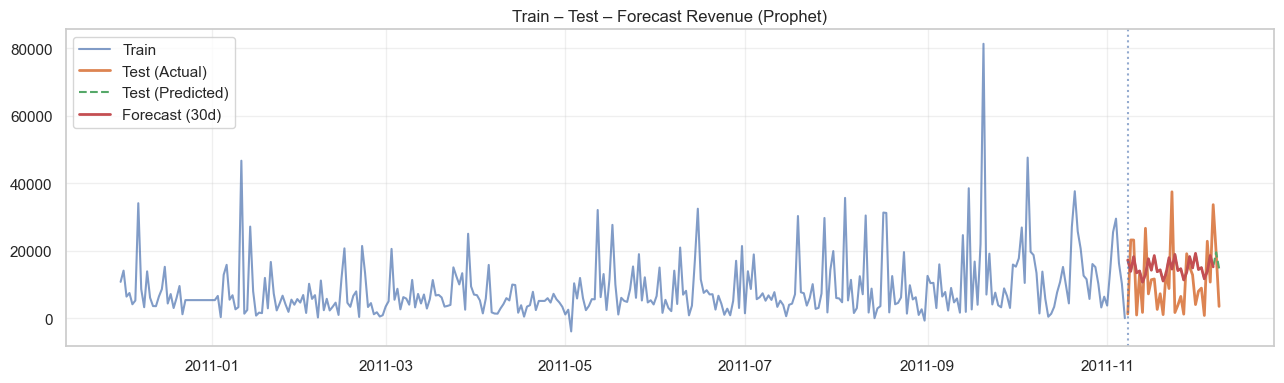

{'forecast_df':           date  forecast_revenue
 342 2011-11-08      17265.404319
 343 2011-11-09      13895.492455
 344 2011-11-10      18231.414061
 345 2011-11-11      13441.020175
 346 2011-11-12      13992.962914
 347 2011-11-13      10681.734018
 348 2011-11-14      12891.314224
 349 2011-11-15      17593.735079
 350 2011-11-16      14223.823215
 351 2011-11-17      18559.744821
 352 2011-11-18      13769.350935
 353 2011-11-19      14321.293674
 354 2011-11-20      11010.064778
 355 2011-11-21      13219.644984
 356 2011-11-22      17922.065839
 357 2011-11-23      14552.153975
 358 2011-11-24      18888.075582
 359 2011-11-25      14097.681695
 360 2011-11-26      14649.624434
 361 2011-11-27      11338.395538
 362 2011-11-28      13547.975744
 363 2011-11-29      18250.396599
 364 2011-11-30      14880.484735
 365 2011-12-01      19216.406342
 366 2011-12-02      14426.012455
 367 2011-12-03      14977.955194
 368 2011-12-04      11666.726298
 369 2011-12-05      13876.306504

In [63]:
forecast_revenue_30d_prophet_with_eval(
    rev_wsale_ts_df,
    time_col = "d",
    value_col = "sum_revenue",
    horizon = 30,
    period = 7,
    show_plot = True
)

#### Phân tích nhóm Vàng

In [64]:
def analyze_segment_ts(
    df: pd.DataFrame,
    filter_col: str,
    filter_value,
    metric: str = "sum_revenue",
):
    """
    One-call time-series analysis:
    Filter → Daily aggregate → Plot → STL decomposition → Insights

    Minimal API by design.
    """

    # -----------------------
    # 0) Filter segment
    # -----------------------
    seg = df[df[filter_col] == filter_value].copy()
    if seg.empty:
        raise ValueError("Filtered dataframe is empty")

    seg["d"] = pd.to_datetime(seg["d"], errors="coerce")
    seg = seg.dropna(subset=["d"])

    # -----------------------
    # 1) Aggregate daily
    # -----------------------
    ts_df = (
        seg
        .groupby("d")
        .agg(
            sum_revenue=("sum_revenue", "sum")
        )
        .reset_index()
        .sort_values("d")
    )
    
    ts_df = fill_missing_by_moving_average(
        ts_df,
        time_col="d",
        value_col ="sum_revenue",
        window = 5,
        freq = "D",
        center = True,
        min_periods = None,
        only_fill_missing_days = True,
        keep_original_time_col = True,
    )
    
    # -----------------------
    # 2) Quick sanity plot
    # -----------------------
    plt.figure(figsize=(12, 4))
    plt.plot(ts_df["d"], ts_df[metric], lw=1.4)
    plt.title(f"{metric} over time ({filter_col} = {filter_value})")
    plt.xlabel("Time")
    plt.ylabel(metric)
    plt.grid(alpha=0.3)
    plt.show()

    # -----------------------
    # 3) Decomposition + insights
    # -----------------------
    result = show_ts_decomposition_insights(
        ts_df,
        time_col="d",
        value_col=metric,
        freq="D",
        agg="sum",
        fill="interpolate",
        robust=True,
        currency=True,
        title=f"{metric} decomposition ({filter_col} = {filter_value})"
    )

    # -----------------------
    # 4) Metadata
    # -----------------------
    result["segment"] = {
        "filter": f"{filter_col} = {filter_value}",
        "rows": len(seg),
        "date_range": (ts_df["d"].min(), ts_df["d"].max())
    }

    return result

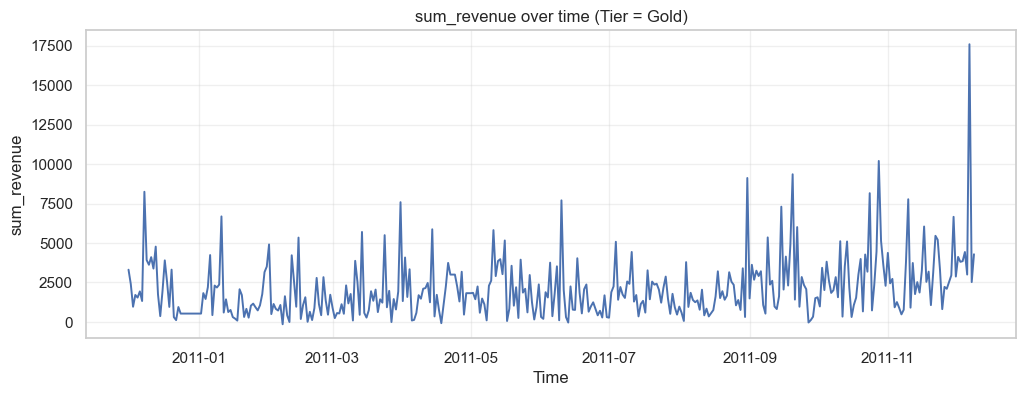

===== Time-Series Decomposition Insights =====
Method: STL | freq=D | period=7
Trend Δ: 3,305 (157.6%)
Seasonality: 5,991 (peak-to-trough)
Residual: 1,535 (std)


{'components':             observed        trend     seasonal     residual
 d                                                          
 2010-12-01   3304.74  1040.970661  1927.141874   336.627466
 2010-12-02   2396.79  1303.737154   811.558832   281.494014
 2010-12-03    956.24  1571.084072  -235.155659  -379.688413
 2010-12-04   1705.21  1840.635789   110.834459  -246.260248
 2010-12-05   1538.30  2110.192046  -607.152378    35.260332
 ...              ...          ...          ...          ...
 2011-12-05   4427.97  4156.205602   116.964441   154.799957
 2011-12-06   2998.33  4214.344373  -892.646090  -323.368283
 2011-12-07  17598.45  4265.318092  3739.885471  9593.246437
 2011-12-08   2521.21  4309.040188 -1631.475465  -156.354722
 2011-12-09   4284.02  4346.206515    26.696783   -88.883297
 
 [374 rows x 4 columns],
 'fig': <Figure size 1400x800 with 4 Axes>,
 'segment': {'filter': 'Tier = Gold',
  'rows': 1038,
  'date_range': (Timestamp('2010-12-01 00:00:00'),
   Timestamp('201

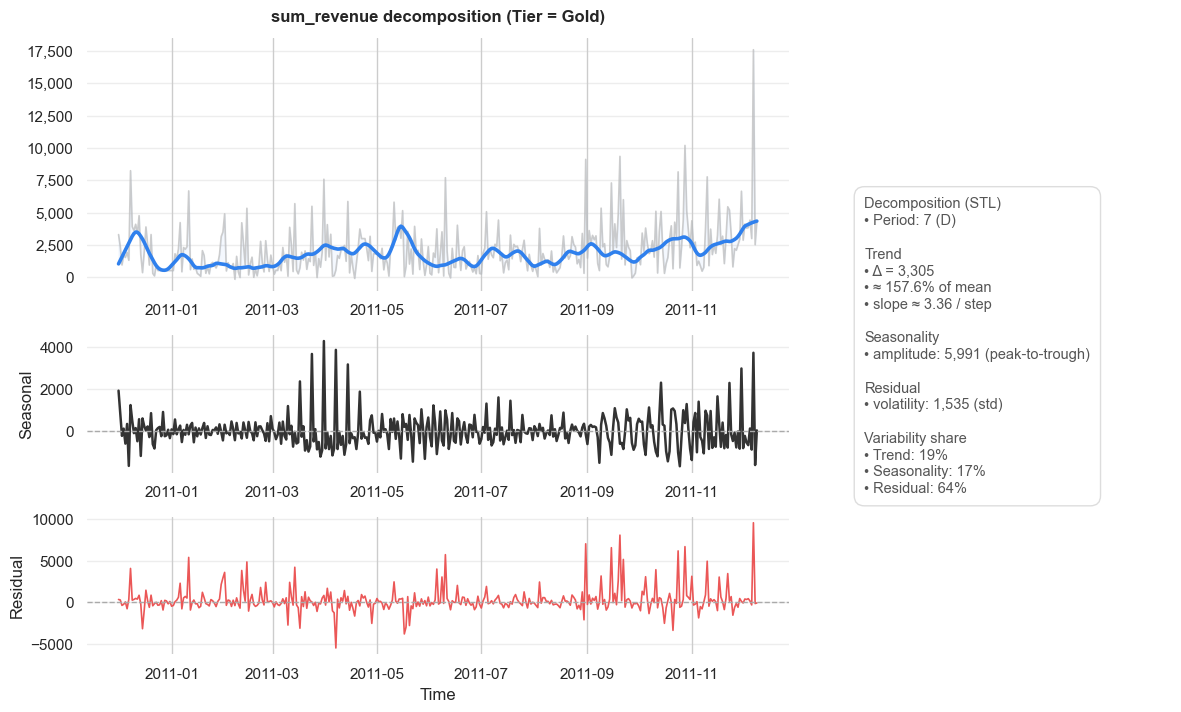

In [65]:
analyze_segment_ts(
    df2,
    filter_col="Tier",
    filter_value="Gold",
    metric = "sum_revenue",
)

#### Phân tích nhóm Bạc

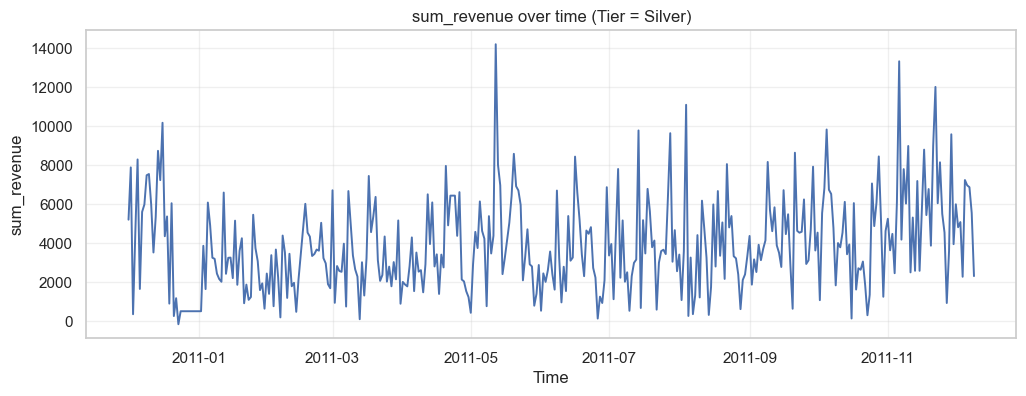

===== Time-Series Decomposition Insights =====
Method: STL | freq=D | period=7
Trend Δ: 1,234 (31.7%)
Seasonality: 8,664 (peak-to-trough)
Residual: 1,703 (std)


{'components':             observed        trend     seasonal     residual
 d                                                          
 2010-12-01   5217.27  3226.700822  1859.844593   130.724585
 2010-12-02   7897.88  3394.983213  4011.027855   491.868932
 2010-12-03    365.70  3570.333718 -2881.317701  -323.316017
 2010-12-04   4557.93  3751.969232   884.595834   -78.635066
 2010-12-05   8305.59  3939.152134 -2822.889937  7189.327803
 ...              ...          ...          ...          ...
 2011-12-05   7249.77  5091.599220  2357.076348  -198.905568
 2011-12-06   6978.81  4945.607060  3184.008790 -1150.805850
 2011-12-07   6881.31  4790.721810  -303.023757  2393.611946
 2011-12-08   5560.82  4629.413274   599.492104   331.914622
 2011-12-09   2322.15  4461.191327 -1269.863678  -869.177649
 
 [374 rows x 4 columns],
 'fig': <Figure size 1400x800 with 4 Axes>,
 'segment': {'filter': 'Tier = Silver',
  'rows': 2599,
  'date_range': (Timestamp('2010-12-01 00:00:00'),
   Timestamp('2

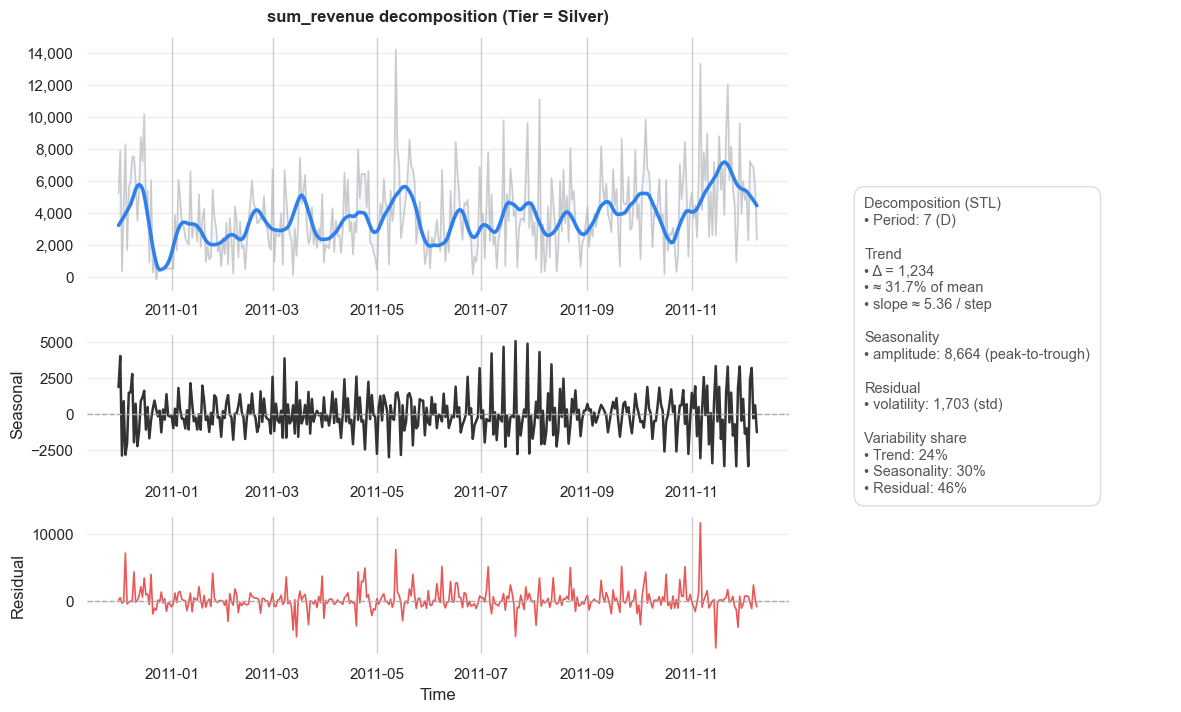

In [66]:
analyze_segment_ts(
    df2,
    filter_col="Tier",
    filter_value="Silver",
    metric = "sum_revenue",
)

#### Phân tích nhóm Đồng

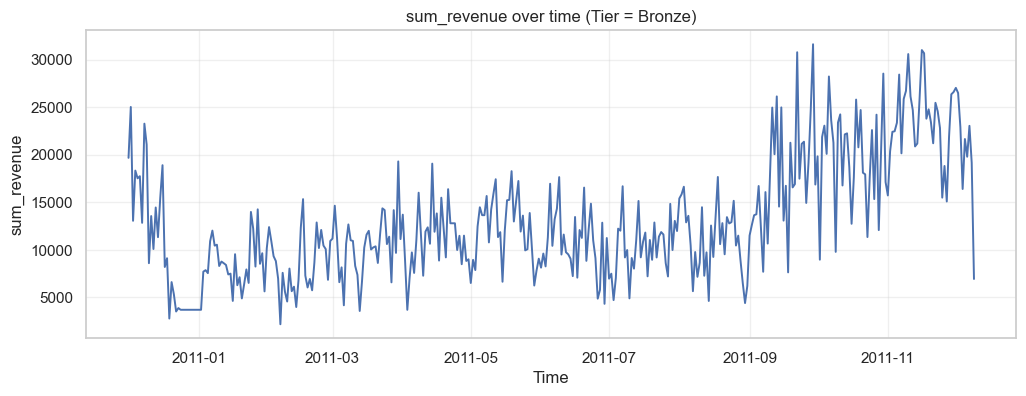

===== Time-Series Decomposition Insights =====
Method: STL | freq=D | period=7
Trend Δ: -3,476 (-26.6%)
Seasonality: 21,190 (peak-to-trough)
Residual: 2,711 (std)


{'components':               observed         trend     seasonal     residual
 d                                                             
 2010-12-01  19676.9300  19746.239499  -268.639434   199.329935
 2010-12-02  25026.5200  19072.777806  6660.811910  -707.069715
 2010-12-03  13060.1200  18396.266139 -5541.728202   205.582063
 2010-12-04  18340.1475  17717.965272   684.719039   -62.536812
 2010-12-05  17525.0200  17039.942463  -685.650190  1170.727727
 ...                ...           ...          ...          ...
 2011-12-05  21655.8700  19395.852795  1750.026885   509.990320
 2011-12-06  19795.7400  18642.559408  2390.975868 -1237.795277
 2011-12-07  23043.4800  17867.633100  5202.289942   -26.443042
 2011-12-08  19151.3200  17075.110564  2538.466350  -462.256914
 2011-12-09   6943.5000  16269.764351 -9624.790122   298.525771
 
 [374 rows x 4 columns],
 'fig': <Figure size 1400x800 with 4 Axes>,
 'segment': {'filter': 'Tier = Bronze',
  'rows': 14070,
  'date_range': (Timestamp

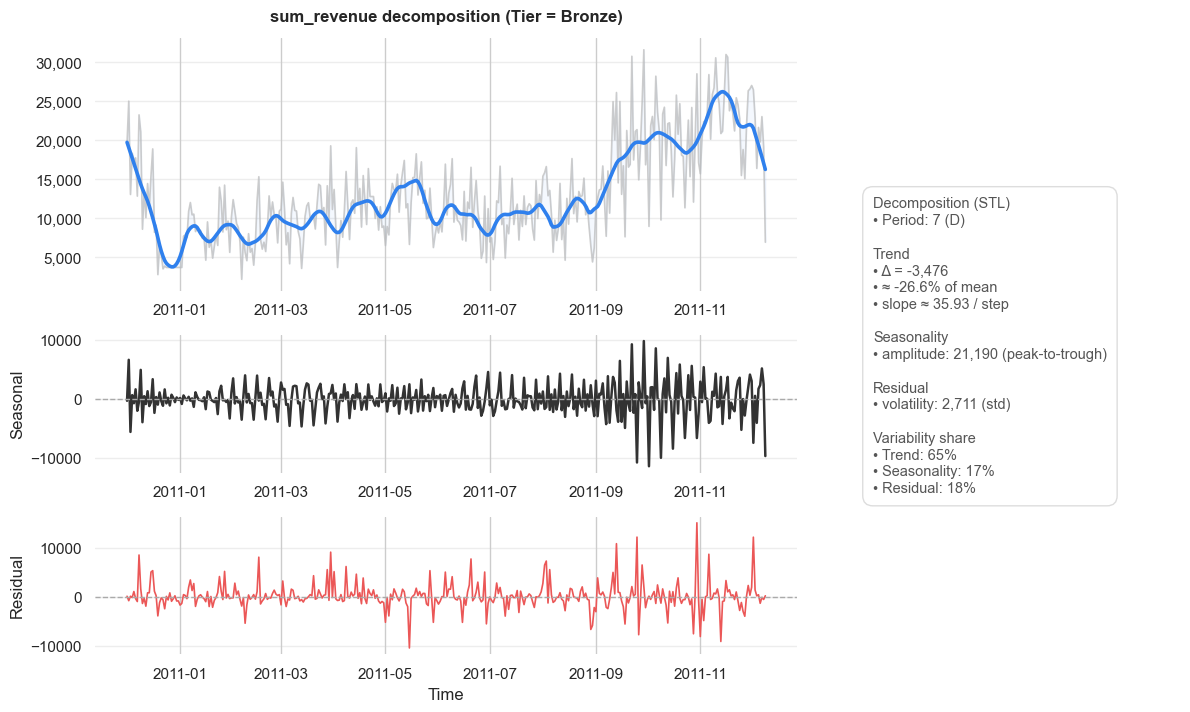

In [67]:
analyze_segment_ts(
    df2,
    filter_col="Tier",
    filter_value="Bronze",
    metric = "sum_revenue",
)